# Compare the base model with the new one

In [1]:
from ultralytics import YOLO
import os
import boto3

In [2]:
BASE_MODEL_BUCKET = "model-registry"
BASE_MODEL_PATH = "models/default/best.pt"
NEW_MODEL_PATH = "models/new-model.pt"

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
AWS_S3_BUCKET = os.environ.get("AWS_S3_BUCKET")
AWS_S3_ENDPOINT = os.environ.get("AWS_S3_ENDPOINT")

In [3]:
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)
client = session.client("s3", endpoint_url=AWS_S3_ENDPOINT)

## Get the models

In [4]:
client.download_file(BASE_MODEL_BUCKET, BASE_MODEL_PATH, "/tmp/base-model.pt")
client.download_file(AWS_S3_BUCKET, NEW_MODEL_PATH, "/tmp/new-model.pt")
client.download_file("data", "validation-dataset.tar.gz", "/tmp/validation-dataset.tar.gz")

In [5]:
! tar -xzf /tmp/validation-dataset.tar.gz

## Base Model Results

In [6]:
model = YOLO("/tmp/base-model.pt")
results = model.val(data = "utils/validation-data.yaml")

Ultralytics YOLOv8.2.32 🚀 Python-3.9.16 torch-2.3.1+cu121 CPU (AMD EPYC 7763 64-Core Processor)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
val: Scanning /opt/app-root/src/activity-notebooks/intelligent-train-dataset/val/labels.cache... 154 images, 7 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


                   all        161        159      0.961      0.879      0.932      0.873
            SpeedLimit         80         81      0.985      0.822      0.908      0.846
           DangerAhead         76         78      0.936      0.935      0.955      0.899
Speed: 0.9ms preprocess, 97.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val17



image 1/1 /opt/app-root/src/activity-notebooks/utils/sample-inference-exemple.jpg: 480x640 1 SpeedLimit, 128.9ms
Speed: 1.5ms preprocess, 128.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


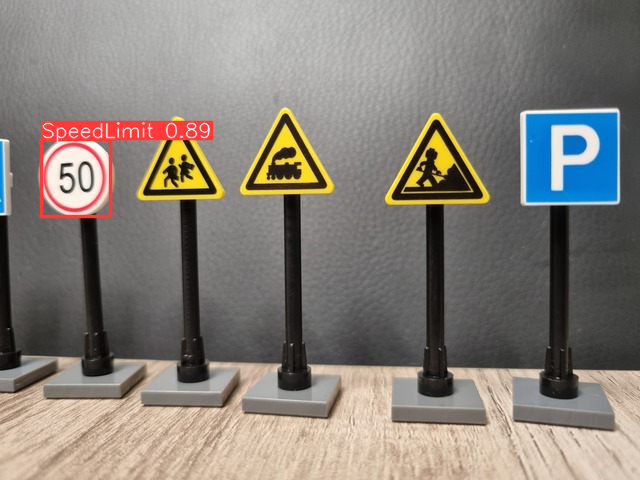

In [7]:
res = model("utils/sample-inference-exemple.jpg")
res[0].show()

## New Model Results

In [8]:
model = YOLO("/tmp/new-model.pt")
results = model.val(data = "utils/validation-data.yaml")

Ultralytics YOLOv8.2.32 🚀 Python-3.9.16 torch-2.3.1+cu121 CPU (AMD EPYC 7763 64-Core Processor)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /opt/app-root/src/activity-notebooks/intelligent-train-dataset/val/labels.cache... 154 images, 7 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


                   all        161        159      0.864      0.825       0.85      0.567
            SpeedLimit         80         81      0.962      0.753      0.834      0.497
           DangerAhead         76         78      0.765      0.897      0.865      0.637
Speed: 1.0ms preprocess, 95.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val18



image 1/1 /opt/app-root/src/activity-notebooks/utils/sample-inference-exemple.jpg: 480x640 1 SpeedLimit, 3 DangerAheads, 122.9ms
Speed: 1.3ms preprocess, 122.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


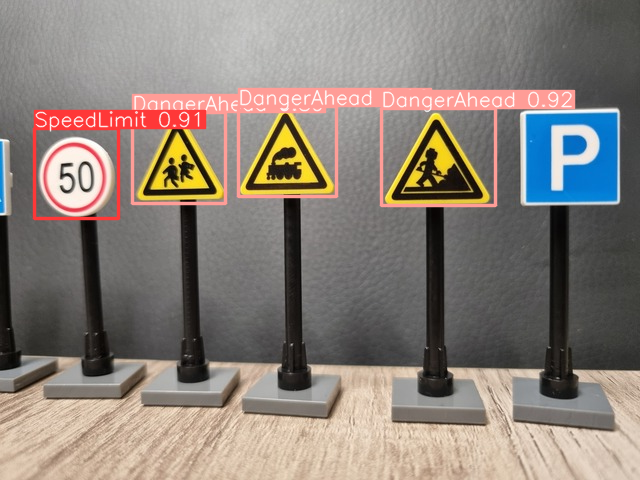

In [9]:
res = model("utils/sample-inference-exemple.jpg")
res[0].show()